In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


df = pd.read_csv('multivariate_eng_df.csv', index_col = 'Date', parse_dates = True)
df.head()

,Unnamed: 0,STATE,PROVINCE_STATE_NAME,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,3160,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-02,3161,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-03,3162,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-04,3163,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-05,3164,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [44]:
X = df.drop(['PEOPLE_POSITIVE_NEW_CASES_COUNT','STATE', 'PROVINCE_STATE_NAME'] , axis=1)
y = df['PEOPLE_POSITIVE_NEW_CASES_COUNT']

#timeseries split for evaluation
tscv = TimeSeriesSplit(n_splits=5)  #adjust based on dataset size and timeframe

In [28]:
#backwards selection
#separate target and features
X = df.drop(['PEOPLE_POSITIVE_NEW_CASES_COUNT','STATE', 'PROVINCE_STATE_NAME'] , axis=1)
y = df['PEOPLE_POSITIVE_NEW_CASES_COUNT']

#timeseries split for evaluation
tscv = TimeSeriesSplit(n_splits=5)  #adjust based on dataset size and timeframe

def backward_feature_selection(X, y, initial_features, tscv):                                                                                                                                                                       
    features = initial_features[:]
    best_features = features[:]
    best_score = float('inf')
    
    while len(features) > 0:
        print(f"Trying {len(features)} features")
        scores = []
        
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index][features], X.iloc[test_index][features]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model = XGBRegressor(n_estimators=75, learning_rate=0.5, objective='reg:squarederror')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = mean_absolute_error(y_test, y_pred)
            scores.append(score)
                                            
        avg_score = np.mean(scores)
        print(f"Average MAE: {avg_score}")
        
        if avg_score < best_score:
            best_score = avg_score
            best_features = features[:]
            if len(features) > 1:
                # Remove the least important feature
                feature_importances = model.feature_importances_
                least_important = np.argmin(feature_importances)
                removed_feature = features.pop(least_important)
                print(f"Removed {removed_feature}, Continuing...")
            else:
                break
        else:
            print("No improvement, stopping.")
            break
            
    return best_features

initial_features = X.columns.tolist()
optimal_features = backward_feature_selection(X, y, initial_features, tscv)

print("Optimal number of features:", len(optimal_features))


Trying 178 features
Average MAE: 2479.2429117615507
Removed Booster_Doses_5Plus, Continuing...
Trying 177 features
Average MAE: 2479.2429117615507
No improvement, stopping.
Optimal number of features: 178


In [29]:
#forwards selection
def forward_feature_selection(X, y, tscv):
    remaining_features = X.columns.tolist()
    selected_features = []
    best_score = float('inf')
    
    while len(remaining_features) > 0:
        score_improvement = False
        best_feature_to_add = None
        
        for feature in remaining_features:
            trial_features = selected_features + [feature]
            print(f"Trying features: {trial_features}")
            scores = []
            
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X.iloc[train_index][trial_features], X.iloc[test_index][trial_features]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                
                model = XGBRegressor(n_estimators=20, learning_rate=0.6, objective='reg:squarederror')
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                score = mean_absolute_error(y_test, y_pred)
                scores.append(score)
            
            avg_score = np.mean(scores)
            print(f"Average MAE with {feature}: {avg_score}")
            
            if avg_score < best_score:
                best_score = avg_score
                best_feature_to_add = feature
                score_improvement = True
        
        if score_improvement:
            selected_features.append(best_feature_to_add)
            remaining_features.remove(best_feature_to_add)
            print(f"Added {best_feature_to_add} to the model, Continuing...")
        else:
            print("No further improvement, stopping.")
            break
            
    return selected_features

optimal_features = forward_feature_selection(X, y, tscv)

print("Optimal features:", optimal_features)
print("Optimal number of features:", len(optimal_features))

Trying features: ['Unnamed: 0']
Average MAE with Unnamed: 0: 5297.8790776122305
Trying features: ['Completeness_pct']
Average MAE with Completeness_pct: 5676.434950636658
Trying features: ['Administered_Dose1_Recip']
Average MAE with Administered_Dose1_Recip: 5267.7333837630895
Trying features: ['Administered_Dose1_Recip_5Plus']
Average MAE with Administered_Dose1_Recip_5Plus: 6710.043825783772
Trying features: ['Administered_Dose1_Recip_12Plus']
Average MAE with Administered_Dose1_Recip_12Plus: 5174.264489004025
Trying features: ['Administered_Dose1_Recip_18Plus']
Average MAE with Administered_Dose1_Recip_18Plus: 5361.197387741692
Trying features: ['Administered_Dose1_Recip_65Plus']
Average MAE with Administered_Dose1_Recip_65Plus: 5651.062001543132
Trying features: ['Series_Complete_Yes']
Average MAE with Series_Complete_Yes: 5014.09559128596
Trying features: ['Series_Complete_5Plus']
Average MAE with Series_Complete_5Plus: 6326.889921393583
Trying features: ['Series_Complete_5to17']

Selected feature: new_cases_7_lag | MAE: 2131.4339417988044 | RMSE: 7776.704365781826
Selected feature: new_cases_1 lag | MAE: 1986.8890834530073 | RMSE: 7430.052067798571
Selected feature: new_cases_350_lag | MAE: 1931.8293273154002 | RMSE: 6768.473932792653
Selected feature: new_cases_10_mean | MAE: 1842.1603291965184 | RMSE: 6425.81591529929
Selected feature: new_cases_10_max | MAE: 1800.2037167056355 | RMSE: 6165.546956111019
Selected feature: Administered_Dose1_Recip_65Plus | MAE: 1769.3079775103681 | RMSE: 6241.943765506971
Selected feature: prop_age04 | MAE: 1751.9496255480772 | RMSE: 6140.389100105485


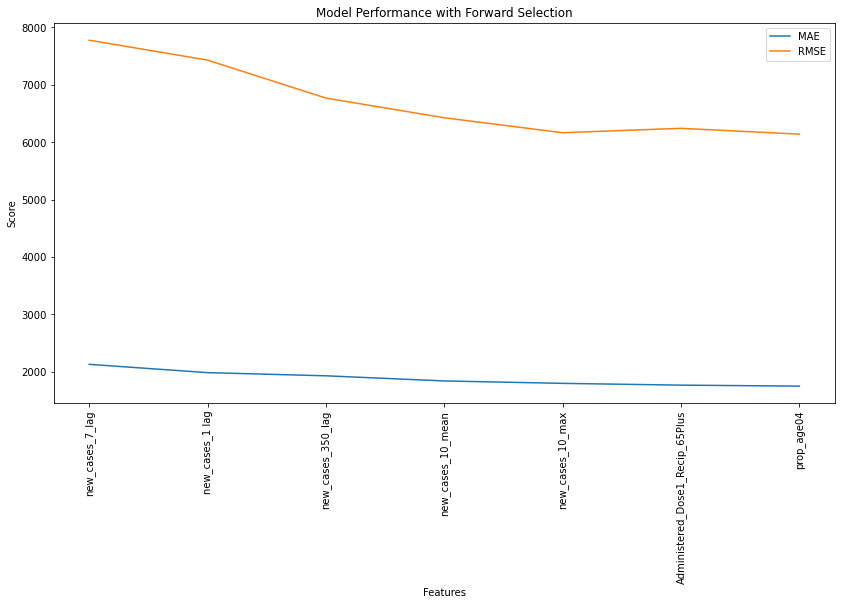

In [46]:
selected_features = []
remaining_features = X.columns.tolist()
model_performance = []

best_mae = float('inf')
best_rmse = float('inf')
best_model = None
best_features = []

for i in range(len(X.columns)):
    best_feature = None
    for feature in remaining_features:
        current_features = selected_features + [feature]
        X_train = X[current_features]
        
        model = XGBRegressor(n_estimators=20, learning_rate=0.7)
        mae_scores = -cross_val_score(model, X_train, y, cv=tscv, scoring='neg_mean_absolute_error')
        rmse_scores = np.sqrt(-cross_val_score(model, X_train, y, cv=tscv, scoring='neg_mean_squared_error'))
        
        mae = np.mean(mae_scores)
        rmse = np.mean(rmse_scores)
        
        if mae < best_mae:
            best_mae = mae
            best_rmse = rmse
            best_feature = feature
            best_model_current = model

    if best_feature:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        model_performance.append((best_mae, best_rmse))
        
        if best_mae < best_mae or best_rmse < best_rmse:
            best_model = best_model_current
            best_features = list(selected_features)
        
        print(f"Selected feature: {best_feature} | MAE: {best_mae} | RMSE: {best_rmse}")
    else:
        break

#plotting the performance
maes, rmses = zip(*model_performance)
plt.figure(figsize=(14, 7))
plt.plot(selected_features, maes, label='MAE')
plt.plot(selected_features, rmses, label='RMSE')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Score')
plt.legend()
plt.title('Model Performance with Forward Selection')
plt.show()
